# Notebook 2 Structure: 
- Variable Preprocessing
- Model implementation
- Feature engineering
- Conclusion
- References
- Appendix


Importing necessary libraries: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tabulate import tabulate
from skopt.space import Integer, Real, Categorical
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    make_scorer, recall_score, accuracy_score, balanced_accuracy_score, 
    f1_score, fbeta_score, roc_auc_score, average_precision_score, 
    matthews_corrcoef, confusion_matrix, confusion_matrix, 
    classification_report)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from skopt import BayesSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, StackingClassifier, 
    GradientBoostingClassifier, HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import shap
from func_3 import format_cm_labels, get_results
from preprocessing import (
    add_indicators, preprocessing_initial, preprocessing_final)
%matplotlib inline

Importing training and test data: 

In [2]:
train = pd.read_csv('../ml_3/train.csv', sep=',')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test = pd.read_csv('/Users/bt/Documents/turing/ml_3/test.csv', sep=',')

In [5]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Now, the training data can be split into training and validation data to test on models. Here, 20% of this data is reserved for validation.

In [6]:
tr, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['Transported'])

In addition, x and y variables can now be defined: 

In [7]:
tr_x = tr.drop(columns=['Transported'])
tr_y = tr['Transported'].astype(int)
val_x = val.drop(columns=['Transported'])
val_y = val['Transported'].astype(int)

# Variable Preprocessing

Now, all preprocessing steps performed in the exploratory data analysis section will be agglomerated here to transform the test and training set in the same way. Functions for these transformations are defined in the preprocessing.py file. 

First, indicator variables are added for columns designated for missing value imputation (numeric variables and VIP column): 

In [8]:
tr_x = add_indicators(tr_x)
val_x = add_indicators(val_x)
real_x_train = add_indicators(test)


Next, columns to standardize, drop, and encode are defined: 

In [9]:
standardize_cols = ['Age', 'group', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'tot_spend']
ordinal_cols = ['RoomService_binned', 'FoodCourt_binned', 'ShoppingMall_binned', 'Spa_binned', 'VRDeck_binned', 'tot_spend_binned']
onehot_cols = ['CryoSleep', 'HomePlanet', 'Destination', 'cabin_deck', 'cabin_side']
imp_med_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_to_drop = ['Name', 'first_name', 'last_name', 'Cabin']

Now, a pipeline to impute missing values in numerical columns by their median is implemented: 

In [10]:
imp_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
preprocessor = ColumnTransformer([
    ('imp', imp_num_pipeline, imp_med_cols)
], remainder='passthrough')

preprocessor.set_output(transform='pandas')
preprocessor.fit(tr_x)

tr_x = preprocessor.transform(tr_x)
val_x = preprocessor.transform(val_x)
real_x_train = preprocessor.transform(real_x_train)

tr_x.columns = tr_x.columns.str.replace(r'^[^_]+__', '', regex=True)
val_x.columns = val_x.columns.str.replace(r'^[^_]+__', '', regex=True)
real_x_train.columns = real_x_train.columns.str.replace(r'^[^_]+__', '', regex=True)

Now, the rest of the preprocessing transformations are applied to the data as seen in the exploratory data analysis section in the first notebook (adding the total amount spent per passenger, binning the skewed numerical variables, imputing missing values for categorical features, splitting the cabin variable into cabin_deck and cabin_side, splitting passenger ID into group number and size).

In [11]:
tr_x = preprocessing_initial(tr_x)
val_x = preprocessing_initial(val_x)
real_x_train = preprocessing_initial(real_x_train)

Now, another pipeline is applied to the data to standardize the numeric variables, and encode the categorical variables: 

In [12]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, standardize_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('onehot', onehot_transformer, onehot_cols)
    ], 
    remainder='passthrough'
)

preprocessor.set_output(transform='pandas')
preprocessor.fit(tr_x)
x_train_processed = preprocessor.transform(tr_x)
x_test_processed = preprocessor.transform(val_x)
real_x_train = preprocessor.transform(real_x_train)

x_train_processed.columns = x_train_processed.columns.str.replace(r'^[^_]+__', '', regex=True)
x_test_processed.columns = x_test_processed.columns.str.replace(r'^[^_]+__', '', regex=True)
real_x_train.columns = real_x_train.columns.str.replace(r'^[^_]+__', '', regex=True)


Next, the designated columns to drop are dropped, and the index is set to be the passenger ID: 

In [13]:
x_train_processed = x_train_processed.drop(cols_to_drop, axis=1)
x_test_processed = x_test_processed.drop(cols_to_drop, axis=1)
real_x_train = real_x_train.drop(cols_to_drop, axis=1)
x_train_processed.set_index('PassengerId', inplace=True)
x_test_processed.set_index('PassengerId', inplace=True)
real_x_train.set_index('PassengerId', inplace=True)

Looking at the processed dataset: 

In [14]:
x_train_processed.head()

,Age,group,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,tot_spend,RoomService_binned,FoodCourt_binned,ShoppingMall_binned,Spa_binned,VRDeck_binned,tot_spend_binned,CryoSleep_False,CryoSleep_True,CryoSleep_nan,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,cabin_deck_0,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_side_0,cabin_side_P,cabin_side_S,VIP,RoomService_missing,FoodCourt_missing,ShoppingMall_missing,Spa_missing,VRDeck_missing,Age_missing,VIP_missing,group_size
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3868_04,-1.996149,-0.277637,-0.33634,-0.279076,-0.305732,-0.267311,-0.264632,-0.517737,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,7
1336_01,-0.811703,-1.226031,-0.33634,-0.279076,-0.305732,-0.267311,-0.264632,-0.517737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,1
9193_01,0.442416,1.716911,-0.33634,-0.279076,-0.305732,-0.267311,-0.264632,-0.517737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,1
5422_01,-0.184643,0.304434,-0.33634,-0.279076,-0.305732,-0.267311,-0.264632,-0.517737,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1,0,0,0,1
5076_01,-1.090396,0.174835,-0.33634,-0.279076,-0.195161,-0.266427,4.423937,1.372395,0.0,0.0,3.0,0.0,5.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,1


# Initial model evaluation: 

Modeling techniques can now be used to try and predict whether a person will be transported to a new dimension or not. In general, all features will be used for each model to establish a baseline.

In terms of modeling, 4 outcomes are possible: 
- True positive: Model predicts transported when the person was transported.
- False positive: Model predicts transported when the person was not transported. 
- True negative: Model predicts not transported when the person was not transported. 
- False negative: Model predicts not transported when the person was not transported.

For this problem, the priority is to correctly classify as many cases as possible, and the most important metric here will be accuracy. In total, metrics observed during model evaluation include: 

- accuracy: this represents the amount of accurate predictions of the model over the number of innacurate predictions. 
- recall: defined as the number of true positives over the sum of true positives and false negatives. 
- precision: defined as the numvber of true positives over the sum of true positives and false positives. 
- weighted F1 score: This value corrects for class imbalance by taking precision and recall's weighted harmonic mean. This ranges from 0-1, where higher values show a better model performance.  
- PR-AUC: this is the area under the precision recall curve and is a measure of the goodnes of balance for precision and recall for the model. Again, values closer to 1 indicate better model performance.  
- MCC: Matthews Correlation Coefficient, which is a helpful metric for imbalanced datasets. This takes all instances of the confusion matrix into account to tell how well the model is able to predict the y values, and ranges from -1 (model does not agree with data labels) to 1 (the model correctly labelled all data). 


Initial model selection: 

Basic models, random forest models, and gradient boosted models are selected initially. As a note, since the original dataset has a lot of multicollinearity, logistic regression will not be used initially as one of its base assumptions are violated. 

Initial models to be used: 
- Dummy model used as a base model. 
- decision tree
- support vector machine (SVM)
- k-nearest neighbors (KNN)
- naive bayes model 

Ensemble and gradient boosted models: 
- Random Forest and Balanced Random Forest
- Gradient boosting and HistGradient boosting. 
- xgboost
- adaboost using a decision tree classifier
- lightgbm

These can go into a dictionary: 

In [15]:
models_initial = {
    'Dummy': DummyClassifier(strategy='most_frequent'),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'Adaboost': AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42),
    random_state=42),
    'lightgbm': LGBMClassifier(random_state=42, objective='binary', metric='accuracy'),
}

Preparing cross validation: 

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Evaluating the initial models: 

In [17]:
r_initial = get_results(models_initial, x_train_processed, tr_y, cv)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503505 -> initscore=0.014021
[LightGBM] [Info] Start training from score 0.014021
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [18]:
r_initial.sort_values(by='accuracy', ascending=False)

,Model,accuracy,average precision,recall,weighted f1,PR AUC,MCC
7,hist_gradient_boosting,0.8082 ± 0.0031,0.7521 ± 0.0038,0.8082 ± 0.0031,0.8082 ± 0.0031,0.7521 ± 0.0038,0.6164 ± 0.0062
10,lightgbm,0.8054 ± 0.0055,0.7494 ± 0.0059,0.8054 ± 0.0055,0.8054 ± 0.0055,0.7494 ± 0.0059,0.6109 ± 0.0109
6,Gradient Boosting,0.8024 ± 0.0038,0.7412 ± 0.0049,0.8024 ± 0.0038,0.8023 ± 0.0038,0.7412 ± 0.0049,0.6053 ± 0.0075
8,XGBoost,0.7990 ± 0.0061,0.7436 ± 0.0075,0.7990 ± 0.0061,0.7989 ± 0.0061,0.7436 ± 0.0075,0.5982 ± 0.0124
2,SVM,0.7965 ± 0.0067,0.7332 ± 0.0078,0.7965 ± 0.0067,0.7962 ± 0.0068,0.7332 ± 0.0078,0.5942 ± 0.0130
5,Random Forest,0.7957 ± 0.0066,0.7440 ± 0.0089,0.7957 ± 0.0066,0.7955 ± 0.0065,0.7440 ± 0.0089,0.5928 ± 0.0137
3,KNN,0.7735 ± 0.0068,0.7156 ± 0.0074,0.7735 ± 0.0068,0.7735 ± 0.0068,0.7156 ± 0.0074,0.5472 ± 0.0136
4,Naive Bayes,0.7688 ± 0.0207,0.7044 ± 0.0253,0.7688 ± 0.0207,0.7669 ± 0.0242,0.7044 ± 0.0253,0.5437 ± 0.0300
9,Adaboost,0.7459 ± 0.0077,0.6868 ± 0.0077,0.7459 ± 0.0077,0.7459 ± 0.0077,0.6868 ± 0.0077,0.4919 ± 0.0154
1,Decision Tree,0.7396 ± 0.0104,0.6803 ± 0.0102,0.7396 ± 0.0104,0.7396 ± 0.0104,0.6803 ± 0.0102,0.4792 ± 0.0209


Storing this result in a table gives: 

Initial model results: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8082 ± 0.0031 | 0.7521 ± 0.0038     | 0.8082 ± 0.0031 | 0.8082 ± 0.0031 | 0.7521 ± 0.0038 | 0.6164 ± 0.0062 |
| lightgbm               | 0.8044 ± 0.0074 | 0.7479 ± 0.0073     | 0.8044 ± 0.0074 | 0.8044 ± 0.0074 | 0.7479 ± 0.0073 | 0.6089 ± 0.0148 |
| Gradient Boosting      | 0.8026 ± 0.0039 | 0.7414 ± 0.0050     | 0.8026 ± 0.0039 | 0.8024 ± 0.0039 | 0.7414 ± 0.0050 | 0.6056 ± 0.0077 |
| XGBoost                | 0.7990 ± 0.0061 | 0.7436 ± 0.0075     | 0.7990 ± 0.0061 | 0.7989 ± 0.0061 | 0.7436 ± 0.0075 | 0.5982 ± 0.0124 |
| Random Forest          | 0.7961 ± 0.0076 | 0.7445 ± 0.0098     | 0.7961 ± 0.0076 | 0.7959 ± 0.0075 | 0.7445 ± 0.0098 | 0.5937 ± 0.0156 |
| Naive Bayes            | 0.7688 ± 0.0207 | 0.7044 ± 0.0253     | 0.7688 ± 0.0207 | 0.7669 ± 0.0242 | 0.7044 ± 0.0253 | 0.5437 ± 0.0300 |
| SVM                    | 0.7610 ± 0.0087 | 0.7036 ± 0.0092     | 0.7610 ± 0.0087 | 0.7610 ± 0.0087 | 0.7036 ± 0.0092 | 0.5224 ± 0.0174 |
| KNN                    | 0.7537 ± 0.0083 | 0.6975 ± 0.0091     | 0.7537 ± 0.0083 | 0.7535 ± 0.0083 | 0.6975 ± 0.0091 | 0.5082 ± 0.0167 |
| Adaboost               | 0.7458 ± 0.0085 | 0.6867 ± 0.0085     | 0.7458 ± 0.0085 | 0.7458 ± 0.0085 | 0.6867 ± 0.0085 | 0.4916 ± 0.0170 |
| Decision Tree          | 0.7394 ± 0.0113 | 0.6802 ± 0.0111     | 0.7394 ± 0.0113 | 0.7394 ± 0.0113 | 0.6802 ± 0.0111 | 0.4789 ± 0.0226 |
| Dummy                  | 0.5036 ± 0.0003 | 0.5036 ± 0.0003     | 0.5036 ± 0.0003 | 0.3373 ± 0.0004 | 0.5036 ± 0.0003 | 0.0000 ± 0.0000 |

The top two models are the histogram-based gradient boosting and lightGBM. These two models only will be used from here for further feature engineering and tuning.

Initial best two models: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8082 ± 0.0031 | 0.7521 ± 0.0038     | 0.8082 ± 0.0031 | 0.8082 ± 0.0031 | 0.7521 ± 0.0038 | 0.6164 ± 0.0062 |
| lightgbm               | 0.8044 ± 0.0074 | 0.7479 ± 0.0073     | 0.8044 ± 0.0074 | 0.8044 ± 0.0074 | 0.7479 ± 0.0073 | 0.6089 ± 0.0148 |

# Initial SHAP examination: 

Looking at Shapley summary plot for both models could help to create new features, or remove unimportant features from the dataset. This gives:

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1969
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380


/Users/bt/Documents/turing/ml_3/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP summary plot for LGBMClassifier:


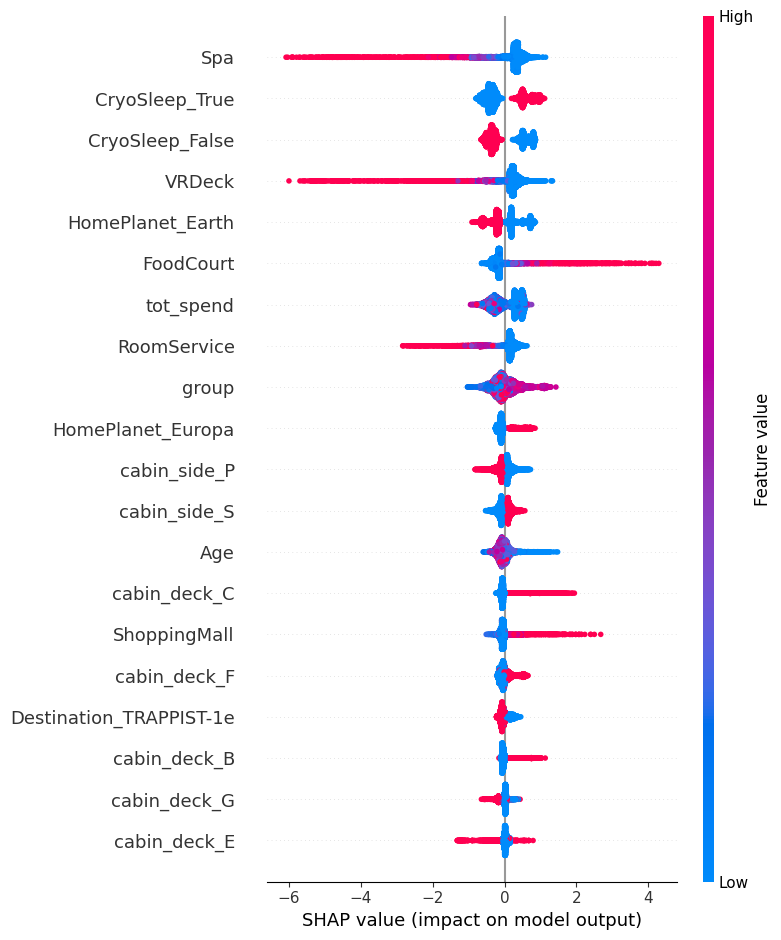

SHAP summary plot for HistGradientBoostingClassifier:


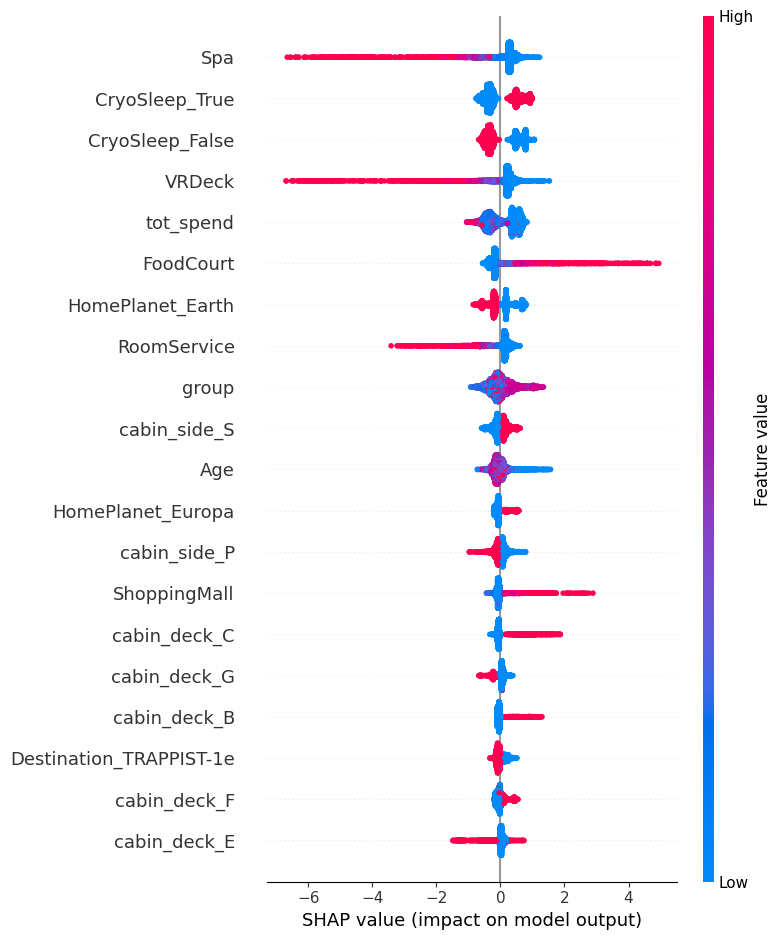

In [19]:
model_lgb = LGBMClassifier().fit(x_train_processed, tr_y)
explainer_lgb = shap.TreeExplainer(model_lgb)
shap_values_lgb = explainer_lgb.shap_values(x_train_processed)

model_hist = HistGradientBoostingClassifier().fit(x_train_processed, tr_y)
explainer_hist = shap.TreeExplainer(model_hist)
shap_values_hist = explainer_hist.shap_values(x_train_processed)

print("SHAP summary plot for LGBMClassifier:")
shap.summary_plot(shap_values_lgb, x_train_processed)
plt.show()

print("SHAP summary plot for HistGradientBoostingClassifier:")
shap.summary_plot(shap_values_hist, x_train_processed)
plt.show()


These plots show that the most important features are Spa, CryoSleep_True or _False, VRDeck, and RoomService for light-gbm, with hist-gb's top features also being Spa, CryoSleep_True or False, followed by tot_spend and VRDeck. Notably, Spa and VRDeck push the transported prediction towards 0, or towards a passenger not being transported. This means that higher spendings in the Spa or VRDeck reduce the chance of a passenger being transported. 

Both plots generally show the same features with the same feature directions, though feature importance to each model varies. 

It could be interesting to test these models with each top feature list only, thus restricting the number of features in each model. Defining these lists for later use here: 

In [20]:
features_shap_lgb = ['Spa', 'CryoSleep_True', 'CryoSleep_False', 'VRDeck', 'tot_spend', 'FoodCourt', 'HomePlanet_Earth', 'RoomService', 'group', 'HomePlanet_Europa', 'cabin_side_S', 'cabin_side_P', 'Age', 'ShoppingMall', 'cabin_deck_C', 'cabin_deck_F', 'Destination_TRAPPIST-1e', 'cabin_deck_G', 'cabin_deck_E', 'HomePlanet_Mars']
features_shap_hist = ['Spa', 'CryoSleep_True', 'CryoSleep_False', 'VRDeck', 'tot_spend', 'FoodCourt', 'HomePlanet_Earth', 'RoomService', 'group', 'HomePlanet_Europa', 'cabin_side_S', 'cabin_side_P', 'Age', 'ShoppingMall', 'cabin_deck_C', 'cabin_deck_G', 'Destination_TRAPPIST-1e', 'cabin_deck_B', 'cabin_deck_E', 'cabin_deck_F']

# Feature Engineering: 

Now, changes can be made to initial data preprocessing methods to try to improve model performance. 

The initial preprocessing adds: 
- Indicator columns for features with imputed values, 
- total_spend feature, 
- group and group_size features derived from PassengerID, 
- cabin_deck and cabin_side features derived from cabin, 
- For numerical variables: 
    - Imputes with median for missing values,
    - Standardization,
    - Binning and ordinal encoding of billed variables, 
- For categorical variables: 
    - Imputes with ‘Missing’ for missing values, and
    - One hot encoding. 

These steps can be modified, and variables can be more carefully selected to increase the accuracy score for the light-gradient boosted model or for the histogram-gradient boosted model. 

Results and explanations for modifications are found in the appendix, and only the final result with the final preprocessing steps are shown here.

## No multicollinearity evaluation:

Looking at the initial model evaluation with the set of features that reduces multicollinearity, just to see the logistic regression model's performance: 

Out of interest, the initial models will be evaluated with the features that give low multicollinearity so as to include a logistic regression model: 

In [21]:
models_initial['Logistic Regression'] = LogisticRegression(random_state=42, max_iter=10000)

In [22]:
v = x_train_processed.drop(['Age', 'cabin_side_S', 'CryoSleep_True', 'CryoSleep_False', 'HomePlanet_Europa', 'ShoppingMall', 'cabin_deck_A', 'cabin_side_0', 'Destination_TRAPPIST-1e', 'tot_spend', 'HomePlanet_Earth'], axis=1)


In [23]:
r = get_results(models_initial, v, tr_y, cv)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1364
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503505 -> initscore=0.014021
[LightGBM] [Info] Start training from score 0.014021
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [24]:
r.sort_values(by='accuracy', ascending=False)

,Model,accuracy,average precision,recall,weighted f1,PR AUC,MCC
7,hist_gradient_boosting,0.8024 ± 0.0038,0.7434 ± 0.0038,0.8024 ± 0.0038,0.8024 ± 0.0038,0.7434 ± 0.0038,0.6049 ± 0.0076
10,lightgbm,0.7997 ± 0.0046,0.7404 ± 0.0036,0.7997 ± 0.0046,0.7996 ± 0.0045,0.7404 ± 0.0036,0.5996 ± 0.0093
6,Gradient Boosting,0.7928 ± 0.0035,0.7277 ± 0.0041,0.7928 ± 0.0035,0.7923 ± 0.0035,0.7277 ± 0.0041,0.5875 ± 0.0069
2,SVM,0.7893 ± 0.0055,0.7248 ± 0.0067,0.7893 ± 0.0055,0.7890 ± 0.0056,0.7248 ± 0.0067,0.5802 ± 0.0105
11,Logistic Regression,0.7889 ± 0.0078,0.7223 ± 0.0086,0.7889 ± 0.0078,0.7882 ± 0.0079,0.7223 ± 0.0086,0.5806 ± 0.0151
8,XGBoost,0.7889 ± 0.0067,0.7308 ± 0.0078,0.7889 ± 0.0067,0.7889 ± 0.0068,0.7308 ± 0.0078,0.5779 ± 0.0135
5,Random Forest,0.7852 ± 0.0093,0.7344 ± 0.0099,0.7852 ± 0.0093,0.7848 ± 0.0094,0.7344 ± 0.0099,0.5729 ± 0.0182
3,KNN,0.7716 ± 0.0117,0.7149 ± 0.0126,0.7716 ± 0.0117,0.7716 ± 0.0117,0.7149 ± 0.0126,0.5438 ± 0.0234
4,Naive Bayes,0.7509 ± 0.0380,0.6828 ± 0.0370,0.7509 ± 0.0380,0.7451 ± 0.0471,0.6828 ± 0.0370,0.5176 ± 0.0554
1,Decision Tree,0.7406 ± 0.0088,0.6816 ± 0.0094,0.7406 ± 0.0088,0.7406 ± 0.0089,0.6816 ± 0.0094,0.4812 ± 0.0178


The top two models here are still the hist-GB model and the light-GB model, which will be the only models used moving forward. These results are worse than the initial ones, the VIF-selected variables will not be selected.

## Changing initial processing techniques: 

Now, the dataset can be modified with the purpose of improving accuracy. This can be done by changing initial processing techniques, creating new features, or by feature selection. Various changes are made one by one to the preprocessing steps, always starting from the defined base parameters. The final result of each change is shown in a table only, to be more concise. A list of all changes and tables is shown in the appendix, to keep the notebook a little cleaner.


Defining the models to be evaluated: 

In [25]:
models = {
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42),
    'lightgbm': LGBMClassifier(random_state=42, objective='binary', metric='accuracy'),
}

### Code flow for each step: 

Showing the code flow for each step (output varies): 

In [26]:
r = get_results(models, x_train_processed, tr_y, cv)
r.sort_values(by='accuracy', ascending=False)
print(tabulate(r, headers='keys', tablefmt='github', showindex=False))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1968
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503505 -> initscore=0.014021
[LightGBM] [Info] Start training from score 0.014021
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

## Combining all feature engineering improvements:

In summary, all feature engineering steps that increased accuracy are: 
- Changing imputation method to the most common category for a feature instead of ‘missing’
- Having no transformations (standardization or normalization) for numerical features
- Adding log-transformed numerical features
- Removing the tot_spend feature
- Adding group*group_size feature or adding group/group_size feature
- Adding spa*vrdeck feature
- Adding (spa*vrdeck)/group_number feature
- Adding (spa*vrdeck)/(roomservice+1)

If all these improvements are combined at once, the resulting accuracy is: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8090 ± 0.0031 | 0.7529 ± 0.0032     | 0.8090 ± 0.0031 | 0.8090 ± 0.0031 | 0.7529 ± 0.0032 | 0.6181 ± 0.0061 |
| lightgbm               | 0.8072 ± 0.0064 | 0.7513 ± 0.0071     | 0.8072 ± 0.0064 | 0.8072 ± 0.0064 | 0.7513 ± 0.0071 | 0.6144 ± 0.0127 |

This is an improvement from the initial accuracy values of 0.8082 for hist-gbm and 0.8044 for light-gbm. If these changes are added one at a time, and a change decreasing the new highest accuracy is removed, this results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8116 ± 0.0043 | 0.7565 ± 0.0052     | 0.8116 ± 0.0043 | 0.8116 ± 0.0043 | 0.7565 ± 0.0052 | 0.6233 ± 0.0086 |
| lightgbm               | 0.8069 ± 0.0054 | 0.7515 ± 0.0058     | 0.8069 ± 0.0054 | 0.8069 ± 0.0054 | 0.7515 ± 0.0058 | 0.6139 ± 0.0107 |

Intermediate results are not shown here, to decrease redundancy slightly. In summary, preprocessing and feature engineering steps that increase overall accuracy are: 
- Having indicator columns for variables with imputed missing values,
- Imputing numerical variables with the median value,
- Log-transforming billed variables,
- Having no further transformations for the numerical variables, 
- Binning and ordinary encoding billed variables, 
- One-hot encoding categorical variables, 
- Adding a total_spending feature, which is the sum of all billed variables,
- Adding a feature which shows group_number over group_size, and another feature for group_numer multiplied with group_size. 

This is shown in the final variable preprocessing section: 


# Final Variable Preprocessing

Defining initial variables: 

In [27]:
tr_x = tr.drop(columns=['Transported'])
tr_y = tr['Transported'].astype(int)
val_x = val.drop(columns=['Transported'])
val_y = val['Transported'].astype(int)

tr_x = add_indicators(tr_x)
val_x = add_indicators(val_x)
real_x_train = add_indicators(test)


Now, a pipeline to impute missing values in numerical columns by their median is implemented: 

In [28]:
imp_num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
preprocessor = ColumnTransformer([
    ('imp', imp_num_pipeline, imp_med_cols)
], remainder='passthrough')

preprocessor.set_output(transform='pandas')
preprocessor.fit(tr_x)

tr_x = preprocessor.transform(tr_x)
val_x = preprocessor.transform(val_x)
real_x_train = preprocessor.transform(real_x_train)

tr_x.columns = tr_x.columns.str.replace(r'^[^_]+__', '', regex=True)
val_x.columns = val_x.columns.str.replace(r'^[^_]+__', '', regex=True)
real_x_train.columns = real_x_train.columns.str.replace(r'^[^_]+__', '', regex=True)

Now, the rest of the preprocessing transformations are applied to the data as seen in the exploratory data analysis section in the first notebook (adding the total amount spent per passenger, binning the skewed numerical variables, imputing missing values for categorical features, splitting the cabin variable into cabin_deck and cabin_side, splitting passenger ID into group number and size).

In [29]:
tr_x = preprocessing_final(tr_x)
val_x = preprocessing_final(val_x)
real_x_train = preprocessing_final(real_x_train)

Now, another pipeline is applied to the data to encode the categorical variables: 

In [30]:
ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])
onehot_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_cols),
        ('onehot', onehot_transformer, onehot_cols)
    ], 
    remainder='passthrough'
)

preprocessor.set_output(transform='pandas')
preprocessor.fit(tr_x)
x_train_processed = preprocessor.transform(tr_x)
x_test_processed = preprocessor.transform(val_x)
real_x_train = preprocessor.transform(real_x_train)

x_train_processed.columns = x_train_processed.columns.str.replace(r'^[^_]+__', '', regex=True)
x_test_processed.columns = x_test_processed.columns.str.replace(r'^[^_]+__', '', regex=True)
real_x_train.columns = real_x_train.columns.str.replace(r'^[^_]+__', '', regex=True)


Next, the designated columns to drop are dropped, and the index is set to be the passenger ID: 

In [31]:
x_train_processed = x_train_processed.drop(cols_to_drop, axis=1)
x_test_processed = x_test_processed.drop(cols_to_drop, axis=1)
real_x_train = real_x_train.drop(cols_to_drop, axis=1)
x_train_processed.set_index('PassengerId', inplace=True)
x_test_processed.set_index('PassengerId', inplace=True)
real_x_train.set_index('PassengerId', inplace=True)

Looking at the processed dataset: 

In [32]:
x_train_processed.head()

,RoomService_binned,FoodCourt_binned,ShoppingMall_binned,Spa_binned,VRDeck_binned,tot_spend_binned,CryoSleep_False,CryoSleep_True,CryoSleep_nan,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_Missing,Destination_55 Cancri e,Destination_Missing,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,cabin_deck_0,cabin_deck_A,cabin_deck_B,cabin_deck_C,cabin_deck_D,cabin_deck_E,cabin_deck_F,cabin_deck_G,cabin_deck_T,cabin_side_0,cabin_side_P,cabin_side_S,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,VIP,RoomService_missing,FoodCourt_missing,ShoppingMall_missing,Spa_missing,VRDeck_missing,Age_missing,VIP_missing,tot_spend,group,group_size,group_div_group_size,group_mul_group_size,RoomService_log,FoodCourt_log,ShoppingMall_log,Spa_log,VRDeck_log,tot_spend_log
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3868_04,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,3868,7,552.571429,27076,0,0,0,0,0,0
1336_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,17.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,1336,1,1336.000000,1336,0,0,0,0,0,0
9193_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,35.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,9193,1,9193.000000,9193,0,0,0,0,0,0
5422_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0.0,5422,1,5422.000000,5422,0,0,0,0,0,0
5076_01,0.0,0.0,3.0,0.0,5.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,13.0,0.0,0.0,60.0,1.0,5147.0,0,0,0,0,0,0,0,0,5208.0,5076,1,5076.000000,5076,0,0,4,0,8,8


# Final Model Evaluation

Evaluating the models with the final preprocessed data: 

In [33]:
models = {
    'hist_gradient_boosting': HistGradientBoostingClassifier(random_state=42),
    'lightgbm': LGBMClassifier(random_state=42, objective='binary', metric='accuracy'),
}

In [34]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [35]:
r = get_results(models, x_train_processed, tr_y, cv)
r.sort_values(by='accuracy', ascending=False)
print(tabulate(r, headers='keys', tablefmt='github', showindex=False))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 5563, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503505 -> initscore=0.014021
[LightGBM] [Info] Start training from score 0.014021
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2801, number of negative: 2762
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Numb

Now, these tuned models can be tuned: 

## Hyperparameter Tuning: 

Defining a scoring dictionary: 

In [36]:
scoring = {
    'recall': make_scorer(recall_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'weighted_f1': make_scorer(f1_score, average='weighted'),
    'f2': make_scorer(fbeta_score, beta=2, average='weighted'),
    'roc_auc': make_scorer(roc_auc_score),
    'average_precision': make_scorer(average_precision_score),
    'mcc': make_scorer(matthews_corrcoef), 
    'pr_auc': make_scorer(average_precision_score, average="macro"),
    'mcc' : make_scorer(matthews_corrcoef),
    'balanced_accuracy' : make_scorer(balanced_accuracy_score)
    }

### Hyperparameter tuning for lightgbm: 

Bayesian optimizaiton is used here.

In [37]:
param_space_lgbm = {
    'n_estimators': (100, 300),              
    'max_depth': (3, 8),                     
    'num_leaves': (15, 63),                  
    'learning_rate': (0.05, 0.2, 'log-uniform'),  
    'min_child_samples': (10, 50),          
    'subsample': (0.7, 1.0),                 
    'colsample_bytree': (0.7, 1.0),          
    'reg_alpha': (1e-4, 1.0, 'log-uniform'), 
    'reg_lambda': (1e-4, 1.0, 'log-uniform'),
    'class_weight': ['balanced', None]
}

lgbm = LGBMClassifier(random_state=42, verbose=-1)
bayes_search = BayesSearchCV(
    estimator=lgbm,
    search_spaces=param_space_lgbm,
    n_iter=100,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0,
    random_state=42
)
bayes_search.fit(x_train_processed, tr_y)
print("Best Parameters:", bayes_search.best_params_)
best_lgbm = bayes_search.best_estimator_

new_row_base = get_results({'best_lgbm': best_lgbm}, x_train_processed, tr_y, cv)
r = pd.concat([r, new_row_base], ignore_index=True)

Best Parameters: OrderedDict({'class_weight': 'balanced', 'colsample_bytree': 1.0, 'learning_rate': 0.06566948008101758, 'max_depth': 6, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 15, 'reg_alpha': 0.0001, 'reg_lambda': 1.0, 'subsample': 0.7})


In [38]:
r.sort_values(by='accuracy', ascending=False)

,Model,accuracy,average precision,recall,weighted f1,PR AUC,MCC
2,best_lgbm,0.8118 ± 0.0039,0.7569 ± 0.0038,0.8118 ± 0.0039,0.8118 ± 0.0039,0.7569 ± 0.0038,0.6237 ± 0.0078
0,hist_gradient_boosting,0.8116 ± 0.0043,0.7565 ± 0.0052,0.8116 ± 0.0043,0.8116 ± 0.0043,0.7565 ± 0.0052,0.6233 ± 0.0086
1,lightgbm,0.8069 ± 0.0054,0.7515 ± 0.0058,0.8069 ± 0.0054,0.8069 ± 0.0054,0.7515 ± 0.0058,0.6139 ± 0.0107


### Hyperparameter tuning for HistGradientBoosting: 

In [39]:

param_space_hgb = {
    'learning_rate': Real(0.01, 0.3),
    'max_iter': Integer(100, 300),
    'max_depth': Integer(1, 15),
    'min_samples_leaf': Integer(5, 50),
    'l2_regularization': Real(0.0, 10.0),
    'max_leaf_nodes': Integer(15, 100),
    'early_stopping': Categorical([False]), 
    'class_weight': Categorical(['balanced', None])
}

hgb = HistGradientBoostingClassifier(random_state=42)

bayes_search = BayesSearchCV(
    estimator=hgb,
    search_spaces=param_space_hgb,
    n_iter=100, 
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0,
    random_state=42
)

bayes_search.fit(x_train_processed, tr_y)
print("Best Parameters:", bayes_search.best_params_)
best_hgb = bayes_search.best_estimator_
new_row_base = get_results({'best_hgb': best_hgb}, x_train_processed, tr_y, cv)
r = pd.concat([r, new_row_base], ignore_index=True)

Best Parameters: OrderedDict({'class_weight': None, 'early_stopping': False, 'l2_regularization': 9.688790013255538, 'learning_rate': 0.21629253012809904, 'max_depth': 14, 'max_iter': 109, 'max_leaf_nodes': 18, 'min_samples_leaf': 16})


In [40]:
r.sort_values(by='accuracy', ascending=False)

,Model,accuracy,average precision,recall,weighted f1,PR AUC,MCC
3,best_hgb,0.8133 ± 0.0022,0.7585 ± 0.0025,0.8133 ± 0.0022,0.8133 ± 0.0022,0.7585 ± 0.0025,0.6268 ± 0.0043
2,best_lgbm,0.8118 ± 0.0039,0.7569 ± 0.0038,0.8118 ± 0.0039,0.8118 ± 0.0039,0.7569 ± 0.0038,0.6237 ± 0.0078
0,hist_gradient_boosting,0.8116 ± 0.0043,0.7565 ± 0.0052,0.8116 ± 0.0043,0.8116 ± 0.0043,0.7565 ± 0.0052,0.6233 ± 0.0086
1,lightgbm,0.8069 ± 0.0054,0.7515 ± 0.0058,0.8069 ± 0.0054,0.8069 ± 0.0054,0.7515 ± 0.0058,0.6139 ± 0.0107


## Stacking models: 

It is possible that stacking these models will increase performance: 

In [41]:

meta_learner = LogisticRegression(random_state=42, max_iter=10000)

stacked_model = StackingClassifier(
    estimators=[
        ('hgb', best_hgb),
        ('lgbm', best_lgbm)
    ],
    final_estimator=meta_learner,
    passthrough=False, 
    cv=5,
    n_jobs=-1
)

stacked_model.fit(x_train_processed, tr_y)
new_row_base = get_results({'stacked': stacked_model}, x_train_processed, tr_y, cv)
r = pd.concat([r, new_row_base], ignore_index=True)

In [42]:
r.sort_values(by='accuracy', ascending=False)

,Model,accuracy,average precision,recall,weighted f1,PR AUC,MCC
3,best_hgb,0.8133 ± 0.0022,0.7585 ± 0.0025,0.8133 ± 0.0022,0.8133 ± 0.0022,0.7585 ± 0.0025,0.6268 ± 0.0043
2,best_lgbm,0.8118 ± 0.0039,0.7569 ± 0.0038,0.8118 ± 0.0039,0.8118 ± 0.0039,0.7569 ± 0.0038,0.6237 ± 0.0078
0,hist_gradient_boosting,0.8116 ± 0.0043,0.7565 ± 0.0052,0.8116 ± 0.0043,0.8116 ± 0.0043,0.7565 ± 0.0052,0.6233 ± 0.0086
4,stacked,0.8112 ± 0.0058,0.7544 ± 0.0061,0.8112 ± 0.0058,0.8112 ± 0.0058,0.7544 ± 0.0061,0.6224 ± 0.0116
1,lightgbm,0.8069 ± 0.0054,0.7515 ± 0.0058,0.8069 ± 0.0054,0.8069 ± 0.0054,0.7515 ± 0.0058,0.6139 ± 0.0107


It looks like stacking these models does not increase when used with training data. 

## Final SHAP examination: 

Looking at Shapley summary plot for both models again can help to explain the relationship between the most important features and the likelihood of a passenger being transported to another dimension: 

/Users/bt/Documents/turing/ml_3/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


SHAP summary plot for LGBMClassifier:


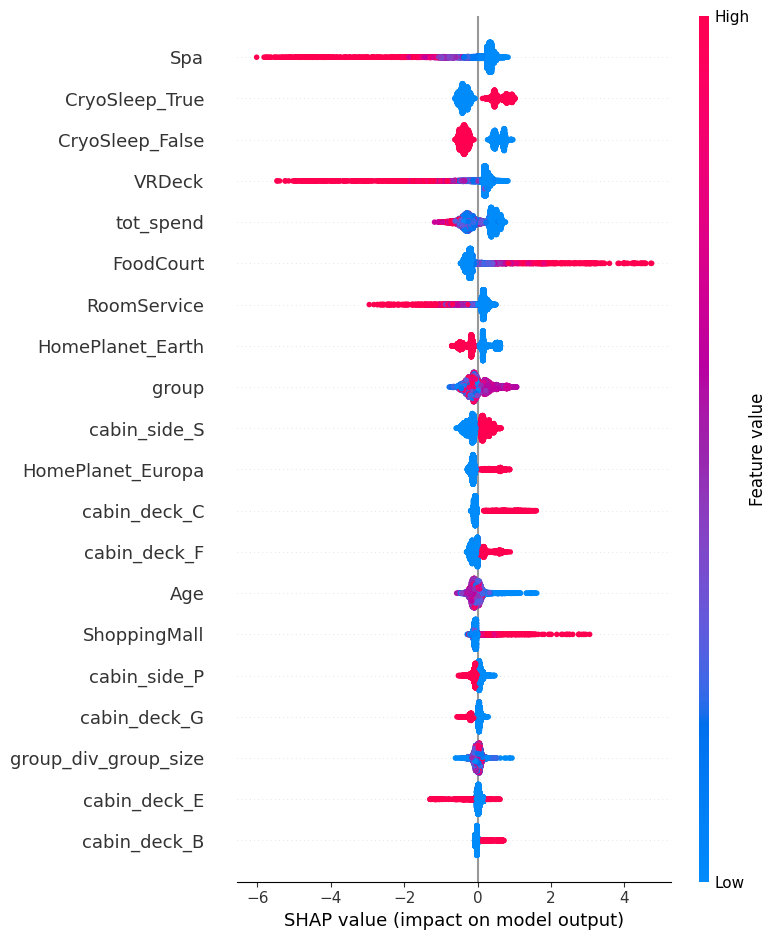

SHAP summary plot for HistGradientBoostingClassifier:


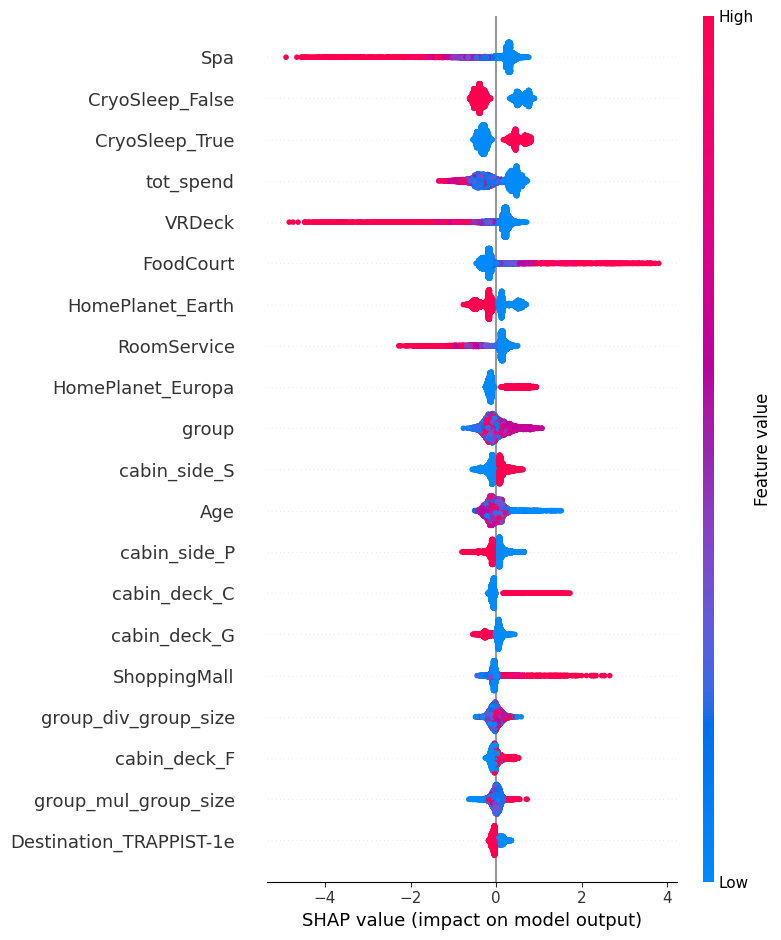

In [43]:
explainer_lgb = shap.TreeExplainer(best_lgbm)
shap_values_lgb = explainer_lgb.shap_values(x_train_processed)

explainer_hist = shap.TreeExplainer(best_hgb)
shap_values_hist = explainer_hist.shap_values(x_train_processed)

print("SHAP summary plot for LGBMClassifier:")
shap.summary_plot(shap_values_lgb, x_train_processed)
plt.show()

print("SHAP summary plot for HistGradientBoostingClassifier:")
shap.summary_plot(shap_values_hist, x_train_processed)
plt.show()


These plots show that the most important features are now the same for both models: Spa, CryoSleep_True or _False, tot_spend, and VRDeck. Notably, Spa, VRDeck, and tot_spend push the transported prediction towards 0, or towards a passenger not being transported. This means that higher spendings in the Spa, VRDeck, or in general reduce the chance of a passenger being transported. Interestingly, the FoodCourt variable shows the opposite trend, where spending more money in the FoodCourt increases chances of being transported to an alternate dimension. These plots also show that passengers that are in cryosleep are also transported more frequently to an alternate dimension. 

Both plots generally show the same features with the same feature directions, though feature importances towards the least important features varies between the two models. 

## Testing on holdout data: 

Testing the light-gbm model on the test data: 

In [44]:
y_pred_lgbm = best_lgbm.predict(x_test_processed)
print(classification_report(val_y, y_pred_lgbm))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       863
           1       0.82      0.80      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



Precision, recall, and f1-score all have scores of 0.81, which is expected from the training data. 

Looking at the classificaiton report of the hist-gbm model: 

In [45]:
y_pred_hgb = best_hgb.predict(x_test_processed)
print(classification_report(val_y, y_pred_hgb))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       863
           1       0.80      0.80      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



These scores are slightly lower than those for the light-gradient boosted model, with all scores being 0.80. 

Now looking at the stacked model's classification report: 

In [46]:
y_pred_stack = stacked_model.predict(x_test_processed)
print(classification_report(val_y, y_pred_hgb))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       863
           1       0.80      0.80      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



This gives the same result as that for the hist-gbm.

Evaluating the three models on the holdout data gives:

In [47]:
y_holdout_proba = best_lgbm.predict_proba(x_test_processed)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(val_y, y_pred_lgbm),
   'precision': average_precision_score(val_y, y_holdout_proba),
    'recall': recall_score(val_y, y_pred_lgbm, average='weighted'),
    'weighted_f1': f1_score(val_y, y_pred_lgbm, average='weighted'),
    'pr_auc': average_precision_score(val_y, y_holdout_proba),
    'mcc': matthews_corrcoef(val_y, y_pred_lgbm)
}

model_name = "Best lgbm-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


r = pd.concat([r, model_results], ignore_index=True)


In [48]:
y_holdout_proba = best_hgb.predict_proba(x_test_processed)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(val_y, y_pred_hgb),
   'precision': average_precision_score(val_y, y_holdout_proba),
    'recall': recall_score(val_y, y_pred_hgb, average='weighted'),
    'weighted_f1': f1_score(val_y, y_pred_hgb, average='weighted'),
    'pr_auc': average_precision_score(val_y, y_holdout_proba),
    'mcc': matthews_corrcoef(val_y, y_pred_hgb)
}

model_name = "Best hgb-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


r = pd.concat([r, model_results], ignore_index=True)

In [49]:
y_holdout_proba = stacked_model.predict_proba(x_test_processed)[:, 1]
metrics_results = {
   'accuracy': accuracy_score(val_y, y_pred_stack),
   'precision': average_precision_score(val_y, y_holdout_proba),
    'recall': recall_score(val_y, y_pred_stack, average='weighted'),
    'weighted_f1': f1_score(val_y, y_pred_stack, average='weighted'),
    'pr_auc': average_precision_score(val_y, y_holdout_proba),
    'mcc': matthews_corrcoef(val_y, y_pred_stack)
}

model_name = "Best stack-holdout"  
model_results = pd.DataFrame([[model_name] + list(metrics_results.values())], 
                             columns=r.columns)


r = pd.concat([r, model_results], ignore_index=True)

In [50]:
r

,Model,accuracy,average precision,recall,weighted f1,PR AUC,MCC
0,hist_gradient_boosting,0.8116 ± 0.0043,0.7565 ± 0.0052,0.8116 ± 0.0043,0.8116 ± 0.0043,0.7565 ± 0.0052,0.6233 ± 0.0086
1,lightgbm,0.8069 ± 0.0054,0.7515 ± 0.0058,0.8069 ± 0.0054,0.8069 ± 0.0054,0.7515 ± 0.0058,0.6139 ± 0.0107
2,best_lgbm,0.8118 ± 0.0039,0.7569 ± 0.0038,0.8118 ± 0.0039,0.8118 ± 0.0039,0.7569 ± 0.0038,0.6237 ± 0.0078
3,best_hgb,0.8133 ± 0.0022,0.7585 ± 0.0025,0.8133 ± 0.0022,0.8133 ± 0.0022,0.7585 ± 0.0025,0.6268 ± 0.0043
4,stacked,0.8112 ± 0.0058,0.7544 ± 0.0061,0.8112 ± 0.0058,0.8112 ± 0.0058,0.7544 ± 0.0061,0.6224 ± 0.0116
5,Best lgbm-holdout,0.810811,0.924466,0.810811,0.810807,0.924466,0.621775
6,Best hgb-holdout,0.801035,0.921682,0.801035,0.801037,0.921682,0.602068
7,Best stack-holdout,0.810236,0.924431,0.810236,0.810237,0.924431,0.620458


In terms of accuracy, the stacked model is the best performing with a score of 0.808511. This is slightly higher than the light gradient boosted model's score of 0.807361, with the histogram-based gradient boosting classifier having the lowest accuracy of 0.801035. 

## Confusion Matrix: 

Finally, the confusion matrix for each model can be examined: 

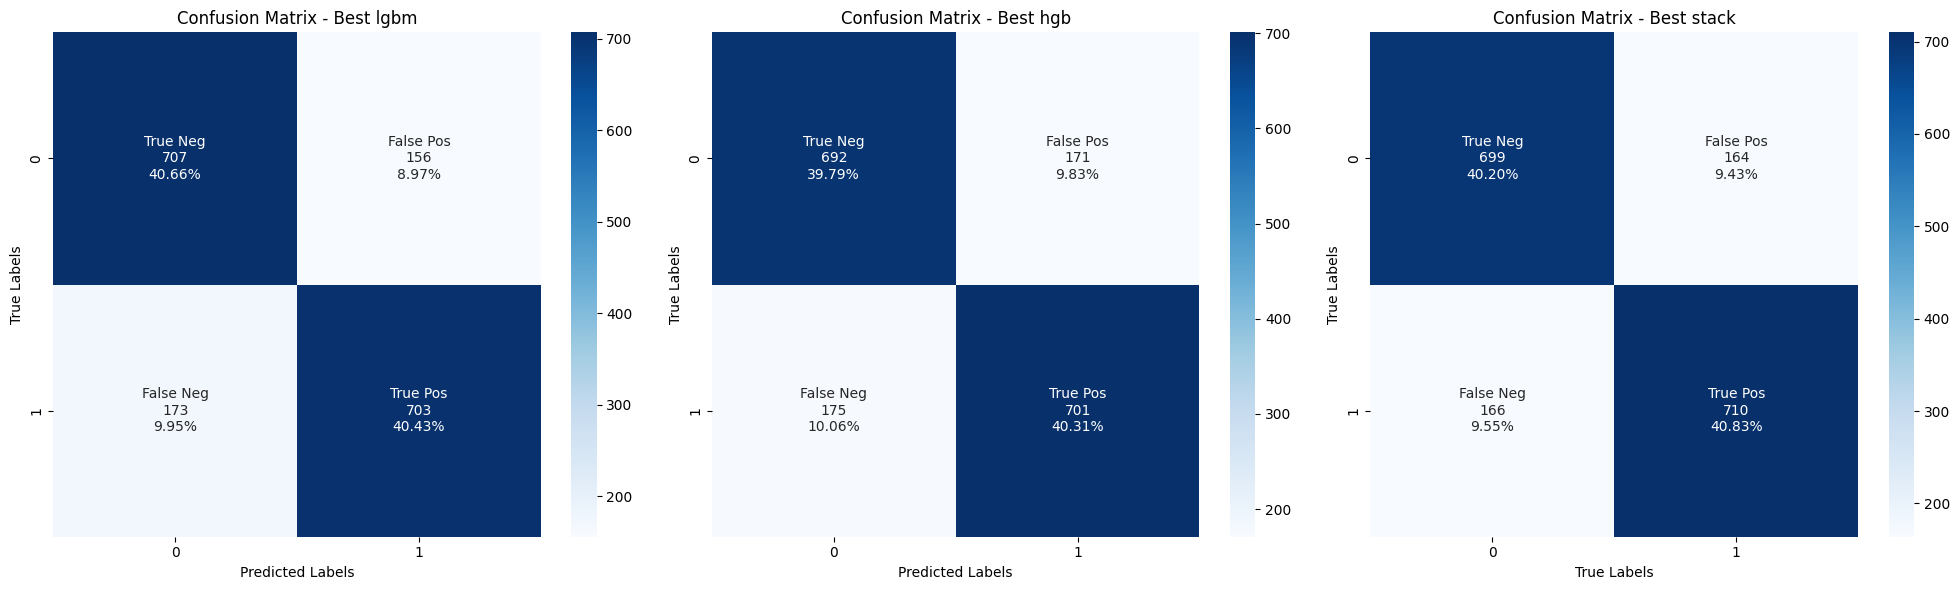

In [51]:
y_pred_lgbm= best_lgbm.predict(x_test_processed)
y_pred_hgb = best_hgb.predict(x_test_processed)
y_pred_stack = stacked_model.predict(x_test_processed)
cm_lgbm= confusion_matrix(val_y, y_pred_lgbm)
cm_hgb= confusion_matrix(val_y, y_pred_hgb)
cm_stack= confusion_matrix(val_y, y_pred_stack)

labels_lgbm = format_cm_labels(cm_lgbm)
labels_hgb = format_cm_labels(cm_hgb)
labels_stack = format_cm_labels(cm_stack)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

sns.heatmap(cm_lgbm, annot=labels_lgbm, fmt="", cmap="Blues", ax=axes[0]).set(title="Confusion Matrix - Best lgbm", xlabel = "Predicted Labels", ylabel = "True Labels")
sns.heatmap(cm_hgb, annot=labels_hgb, fmt="", cmap="Blues", ax=axes[1]).set(title="Confusion Matrix - Best hgb", xlabel = "Predicted Labels", ylabel = "True Labels")
sns.heatmap(cm_stack, annot=labels_stack, fmt="", cmap="Blues", ax=axes[2]).set(title="Confusion Matrix - Best stack", xlabel = "Predicted Labels", ylabel = "True Labels")

axes[0].set_title("Confusion Matrix - Best lgbm")
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")

axes[1].set_title("Confusion Matrix - Best hgb")
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")

axes[2].set_title("Confusion Matrix - Best stack")
axes[2].set_xlabel("Predicted Labels")
axes[2].set_xlabel("True Labels")

plt.tight_layout()
plt.show()


The confusion matrix shows that the light gradient boosted model is the best at correctly classifying true negatives, while the stacked model is the best at correctly classifying true positives. Overall, the highest accuracy goes to the stacked model, though its performance is very close to that of the light-gbm.

## Exporting results: 

Now, results can be exported for submission in the Kaggle competition: 

In [52]:
y_pred = stacked_model.predict(real_x_train)
results_df = test[['PassengerId']].copy()
results_df['Transported'] = y_pred.astype(bool)


In [53]:
results_df.to_csv('submission.csv', index=False)

Checking to make sure that the results are in the right format: 

In [54]:
results_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


After submission to Kaggle, this prediction has received a score of 0.80453, which is acceptable for this project.

# Summary and Conclusions: 

This project had objective of classifying passengers on the _Spaceship Titanic_ that were transported to a new dimension post dust cloud collision. To do this, the data was explored and statistically tested before applying various machine learning models, and tuning these to obtain the highest accuracy possible. 

So far, exploratory data analysis has shown that: 
- Passengers are generally aged 20-40 years old, 
- 50% of passengers do not spend any money on billed variables (Room Service, Rood Court, Shopping Mall, Spa, and VRDeck), 
- Most people travel alone, 
- Most people are from Earth, 
- Most people did not choose to be in cryosleep, 
- The largest cabin_decks are G and F, and the smallest is cabin deck T. 
- Most people are travelling to TRAPPIST-1e, 
- Most people are not VIP passengers, and most people have unique names. 

As for passengers transported to another dimension, 
- This accounts for about half of total passengers (in the training data set).
- Passengers that spend a total of over 750$ are less likely to get transported to another dimension. 
- Passengers travelling in group sizes from 2-7 people are transported a little more often than not. 
- Passengers from Europa have the highest rate of being transported compared to passengers from Earth or Mars. 
- Those in cryosleep have a higher chance of being transported than not (about 82% of those in cryosleep were transported to another dimension). 
- Passengers travelling to 55 Cancri e have a slightly higher chance of being transported than not.


Statistical inference found that a quite a few features are related to transportation incidence to an alternate dimension, and are: 
- VIP,
- All billed variables (RoomService_binned, FoodCourt_binned, ShoppingMall_binned, Spa_binned, VRDeck_binned, and tot_spend_binned), 
- group_size, 
- CryoSleep, 
- HomePlanet_Europa and HomePlanet_Earth, 
- Destination 55 Cancri e and TRAPPIST-1e, 
- Cabin_deck_B, C, D, E, F, 
- Cabin_side,
- Age, and group number. 

From here, various models were tested on the training data. Gradient boosted models were found to be the best performing, and light-gbm was compared with hist-gbm to find the best accuracy overall while modifying features. These models were also stacked together to obtain a slightly higher accuracy. The final highest accuracy for test data was found to be 0.808511 with the stacked model, which corresponds to a score of 0.80453 on Kaggle’s submission board. This has a purpose of helping to correctly classify missing passengers from the spaceship and hopefully bring them to safety. 

The most important features for the tuned models were found to be the same using Shapley value plots: Spa, CryoSleep_True or _False, tot_spend, and VRDeck. Notably, Spa, VRDeck, and tot_spend push the transported prediction towards 0, or towards a passenger not being transported. This means that higher spendings in the Spa, VRDeck, or in general reduce the chance of a passenger being transported. Interestingly, the FoodCourt variable shows the opposite trend, where spending more money in the FoodCourt increases chances of being transported to an alternate dimension. In addition, passengers that are in cryosleep are also transported more frequently to an alternate dimension. 

To further improve this project, an automated feature engineering using a package such as feature tools could have been examined, to further enhance feature selection. Principal component analysis or another form of automated feature selection could also have been performed prior to final model selection, to ensure that the models used the most important features only, and could have helped for model explainability. In addition, additional models could have been tuned and added to the stacked model to hopefully improve accuracy score even more. 


# References: 

- Addison Howard, Ashley Chow, and Ryan Holbrook. Spaceship Titanic. https://kaggle.com/competitions/spaceship-titanic, 2022. Kaggle.
- ChatGPT.


# Appendix: Feature engineering exact steps and results

## Feature Engineering Intermediate Results

Following are shown tables of results for each described change to data processing techniques or feature modifications: 

### Numerical variables imputation method as mean instead of median

To start, looking at what happens if the initial imputation method for numeric variables is with 'mean' and not 'median': 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8049 ± 0.0049 | 0.7499 ± 0.0060     | 0.8049 ± 0.0049 | 0.8048 ± 0.0049 | 0.7499 ± 0.0060 | 0.6099 ± 0.0098 |
| lightgbm               | 0.8041 ± 0.0053 | 0.7475 ± 0.0065     | 0.8041 ± 0.0053 | 0.8041 ± 0.0053 | 0.7475 ± 0.0065 | 0.6083 ± 0.0105 |

The accuracy here is lower than that of the initial models (0.8082 for hist_gradient_boosting). 

### Numerical features normalized

If the numerical features are normalized instead of standardized, this results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8082 ± 0.0031 | 0.7521 ± 0.0038     | 0.8082 ± 0.0031 | 0.8082 ± 0.0031 | 0.7521 ± 0.0038 | 0.6164 ± 0.0062 |
| lightgbm               | 0.8054 ± 0.0055 | 0.7494 ± 0.0059     | 0.8054 ± 0.0055 | 0.8054 ± 0.0055 | 0.7494 ± 0.0059 | 0.6109 ± 0.0109 |

This is essentially the same as with the initial version, with slightly higher performance for lightgbm. 

### No standardization or normalization for numerical features:

This results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8085 ± 0.0035 | 0.7524 ± 0.0042     | 0.8085 ± 0.0035 | 0.8085 ± 0.0035 | 0.7524 ± 0.0042 | 0.6170 ± 0.0070 |
| lightgbm               | 0.8043 ± 0.0072 | 0.7482 ± 0.0078     | 0.8043 ± 0.0072 | 0.8043 ± 0.0072 | 0.7482 ± 0.0078 | 0.6087 ± 0.0144 |

This results in slightly higher performance for the hist_gradient boosted model, and about the same performance for the lightgbm as compared to the first models tested. 

### Changing bin sizes for binned variables

What if the bin sizes are changed for the billed variables? In this case, there are three bins (0, 1-500, and 500+, or 0, 1-750, 750+ for tot_spend): 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8054 ± 0.0029 | 0.7482 ± 0.0029     | 0.8054 ± 0.0029 | 0.8054 ± 0.0029 | 0.7482 ± 0.0029 | 0.6109 ± 0.0058 |
| lightgbm               | 0.8044 ± 0.0031 | 0.7472 ± 0.0037     | 0.8044 ± 0.0031 | 0.8044 ± 0.0031 | 0.7472 ± 0.0037 | 0.6089 ± 0.0061 |

This decreased the accuracy for both models. 

### Categorical variables imputation method as mode instead of 'missing'

If the missing categorical values are imputed as the most commun category of each group (for example, Earth for HomePlanet), this results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8092 ± 0.0056 | 0.7527 ± 0.0060     | 0.8092 ± 0.0056 | 0.8092 ± 0.0057 | 0.7527 ± 0.0060 | 0.6184 ± 0.0112 |
| lightgbm               | 0.8059 ± 0.0049 | 0.7482 ± 0.0055     | 0.8059 ± 0.0049 | 0.8058 ± 0.0049 | 0.7482 ± 0.0055 | 0.6118 ± 0.0099 |

This is an improvement to the initial model's accuracy.

### Add log transformation for numerical features

Adding log-transformed numerical features gives: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8089 ± 0.0038 | 0.7531 ± 0.0040     | 0.8089 ± 0.0038 | 0.8089 ± 0.0038 | 0.7531 ± 0.0040 | 0.6178 ± 0.0076 |
| lightgbm               | 0.8080 ± 0.0062 | 0.7522 ± 0.0071     | 0.8080 ± 0.0062 | 0.8080 ± 0.0062 | 0.7522 ± 0.0071 | 0.6162 ± 0.0123 |

There is a slight increase in accuracy here as compared to the base models.

### What if the indicator columns are removed? 

This results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8067 ± 0.0058 | 0.7503 ± 0.0069     | 0.8067 ± 0.0058 | 0.8067 ± 0.0058 | 0.7503 ± 0.0069 | 0.6135 ± 0.0115 |
| lightgbm               | 0.8063 ± 0.0050 | 0.7503 ± 0.0050     | 0.8063 ± 0.0050 | 0.8063 ± 0.0051 | 0.7503 ± 0.0050 | 0.6127 ± 0.0100 |

Removing indicator columns for missing values decreases accuracy of models.

### What if the binned variables are removed? 

This results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8076 ± 0.0025 | 0.7509 ± 0.0034     | 0.8076 ± 0.0025 | 0.8076 ± 0.0025 | 0.7509 ± 0.0034 | 0.6152 ± 0.0050 |
| lightgbm               | 0.8069 ± 0.0052 | 0.7508 ± 0.0064     | 0.8069 ± 0.0052 | 0.8069 ± 0.0052 | 0.7508 ± 0.0064 | 0.6138 ± 0.0104 |

Removing binned variables also decreases accuracy for these two models.

### What if the raw billed variables are removed? 

This results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.7955 ± 0.0088 | 0.7398 ± 0.0088     | 0.7955 ± 0.0088 | 0.7955 ± 0.0088 | 0.7398 ± 0.0088 | 0.5913 ± 0.0173 |
| lightgbm               | 0.7965 ± 0.0078 | 0.7409 ± 0.0080     | 0.7965 ± 0.0078 | 0.7965 ± 0.0078 | 0.7409 ± 0.0080 | 0.5933 ± 0.0155 |

Having both raw billed variables as well as their binned counterparts increases model accuracy it seems. 

### What if the tot_spend feature is removed? 

This results in: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8090 ± 0.0043 | 0.7537 ± 0.0055     | 0.8090 ± 0.0043 | 0.8090 ± 0.0043 | 0.7537 ± 0.0055 | 0.6182 ± 0.0087 |
| lightgbm               | 0.8064 ± 0.0044 | 0.7505 ± 0.0053     | 0.8064 ± 0.0044 | 0.8064 ± 0.0044 | 0.7505 ± 0.0053 | 0.6130 ± 0.0089 |

Which increases the accuracy of both models slightly. If tot_spend is removed as well as tot_spend_binned, the resulting table is: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8062 ± 0.0020 | 0.7502 ± 0.0022     | 0.8062 ± 0.0020 | 0.8061 ± 0.0020 | 0.7502 ± 0.0022 | 0.6124 ± 0.0039 |
| lightgbm               | 0.8054 ± 0.0031 | 0.7489 ± 0.0040     | 0.8054 ± 0.0031 | 0.8054 ± 0.0031 | 0.7489 ± 0.0040 | 0.6110 ± 0.0063 |

This is less accurate than the original hist-gbm model with 0.8082 accuracy.


### Shap features light-gbm

Using the features shown in light-gbm's plot only gives: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8046 ± 0.0049 | 0.7481 ± 0.0052     | 0.8046 ± 0.0049 | 0.8046 ± 0.0049 | 0.7481 ± 0.0052 | 0.6092 ± 0.0098 |
| lightgbm               | 0.8028 ± 0.0051 | 0.7465 ± 0.0051     | 0.8028 ± 0.0051 | 0.8028 ± 0.0051 | 0.7465 ± 0.0051 | 0.6058 ± 0.0101 |

Restricting the model's features results in a lower accuracy than the original model. 

### Shap features hist-gbm

Evaluating the models with features shown in the hist-gbm's plot only gives: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8069 ± 0.0053 | 0.7508 ± 0.0049     | 0.8069 ± 0.0053 | 0.8069 ± 0.0053 | 0.7508 ± 0.0049 | 0.6138 ± 0.0104 |
| lightgbm               | 0.8039 ± 0.0061 | 0.7469 ± 0.0070     | 0.8039 ± 0.0061 | 0.8039 ± 0.0061 | 0.7469 ± 0.0070 | 0.6077 ± 0.0123 

This also results in lower overall accuracy than the first hist-gbm accuracy of 0.8082, and suggests that even unimportant features still contribute slightly to having better predictions for both models. 

Now, some features can be combined together to see if adding new features improves prediction accuracy. These features are added in the new_feat function in the preprocessing.py file.

### Add feature: group and group_size

Adding a new feature (group_mul_group_size), which is equal to a passenger's group number multiplied with their group size gives: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8098 ± 0.0056 | 0.7548 ± 0.0059     | 0.8098 ± 0.0056 | 0.8097 ± 0.0056 | 0.7548 ± 0.0059 | 0.6197 ± 0.0111 |
| lightgbm               | 0.8073 ± 0.0068 | 0.7512 ± 0.0076     | 0.8073 ± 0.0068 | 0.8073 ± 0.0068 | 0.7512 ± 0.0076 | 0.6148 ± 0.0136 |

This is an increase in accuracy as compared to the initial case of 0.8082. 

Looking at group / group_size gives:

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8100 ± 0.0031 | 0.7543 ± 0.0030     | 0.8100 ± 0.0031 | 0.8100 ± 0.0031 | 0.7543 ± 0.0030 | 0.6201 ± 0.0061 |
| lightgbm               | 0.8059 ± 0.0071 | 0.7497 ± 0.0077     | 0.8059 ± 0.0071 | 0.8059 ± 0.0071 | 0.7497 ± 0.0077 | 0.6118 ± 0.0140 |

This also shows an increase in accuracy with the addition of the group_div_group_size feature.

### Add feature: spa and vrdeck

Combining top features from the SHAP plots could increase model accuracy. Spa and vrdeck were important features for both models. Looking at the results from adding a feature that multiplies spa and vrdeck together gives: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8093 ± 0.0023 | 0.7536 ± 0.0024     | 0.8093 ± 0.0023 | 0.8093 ± 0.0023 | 0.7536 ± 0.0024 | 0.6187 ± 0.0044 |
| lightgbm               | 0.8070 ± 0.0027 | 0.7512 ± 0.0034     | 0.8070 ± 0.0027 | 0.8070 ± 0.0027 | 0.7512 ± 0.0034 | 0.6141 ± 0.0055 |

This increases accuracy for both models as compared to the initial version. Looking at the results from adding spa / (vrdeck + 1), where one is added to the denominator, as many values are equal to zero, gives:

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8066 ± 0.0049 | 0.7508 ± 0.0052     | 0.8066 ± 0.0049 | 0.8066 ± 0.0049 | 0.7508 ± 0.0052 | 0.6133 ± 0.0098 |
| lightgbm               | 0.8086 ± 0.0074 | 0.7522 ± 0.0079     | 0.8086 ± 0.0074 | 0.8086 ± 0.0074 | 0.7522 ± 0.0079 | 0.6173 ± 0.0148 |

This addition decreased accuracy for hist-gbm and increased the accuracy for the light-gbm.

### Add feature: spa, vrdeck, and group

Since combinations of spa and vrdeck, as well as group and group_size increased model accuracy, maybe looking at linear combinations of these variables could also improve model accuracy. 

To start, looking at results for (spa*vrdeck)/group_number:

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8095 ± 0.0052 | 0.7531 ± 0.0063     | 0.8095 ± 0.0052 | 0.8095 ± 0.0052 | 0.7531 ± 0.0063 | 0.6190 ± 0.0104 |
| lightgbm               | 0.8086 ± 0.0045 | 0.7521 ± 0.0045     | 0.8086 ± 0.0045 | 0.8086 ± 0.0045 | 0.7521 ± 0.0045 | 0.6172 ± 0.0090 |

This increases accuracy for both models as compared to the base case (0.082 for hist-gbm and 0.8044 for light-gbm).

Now, looking at results for the inverse of this: group_number / ((spa*vrdeck) + 1) gives: 

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8073 ± 0.0028 | 0.7513 ± 0.0023     | 0.8073 ± 0.0028 | 0.8073 ± 0.0028 | 0.7513 ± 0.0023 | 0.6147 ± 0.0055 |
| lightgbm               | 0.8054 ± 0.0066 | 0.7483 ± 0.0071     | 0.8054 ± 0.0066 | 0.8054 ± 0.0066 | 0.7483 ± 0.0071 | 0.6109 ± 0.0131 |

This does not improve model accuracy.

### Add feature: spa, vrdeck, and roomservice

Another important feature seen in the SHAP plot overview was roomservice. What if this feature is added with the combined spa_vrdeck features? Looking at accuracy when adding in (spa*vrdeck)/(roomservice+1):

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8080 ± 0.0069 | 0.7522 ± 0.0074     | 0.8080 ± 0.0069 | 0.8080 ± 0.0069 | 0.7522 ± 0.0074 | 0.6161 ± 0.0138 |
| lightgbm               | 0.8096 ± 0.0065 | 0.7533 ± 0.0056     | 0.8096 ± 0.0065 | 0.8096 ± 0.0065 | 0.7533 ± 0.0056 | 0.6193 ± 0.0130 |

The accuracy for hist_gradient_boosting is about the same as that of the initial models, but the one for lightgbm increased from 0.8044 to 0.8096! 

Looking at accuracy when adding these features multiplied together, spa* vrdeck* roomservice:

| Model                  | accuracy        | average precision   | recall          | weighted f1     | PR AUC          | MCC             |
|------------------------|-----------------|---------------------|-----------------|-----------------|-----------------|-----------------|
| hist_gradient_boosting | 0.8051 ± 0.0064 | 0.7487 ± 0.0077     | 0.8051 ± 0.0064 | 0.8051 ± 0.0064 | 0.7487 ± 0.0077 | 0.6103 ± 0.0128 |
| lightgbm               | 0.8093 ± 0.0063 | 0.7535 ± 0.0066     | 0.8093 ± 0.0063 | 0.8093 ± 0.0063 | 0.7535 ± 0.0066 | 0.6187 ± 0.0126 |

This shows a similar increase in accuracy for the lightgbm model, and a decrease in accuracy for the hist-gbm model. 